In [100]:
##librerías
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import tensorflow as tf 
from tensorflow import keras
import keras_tuner as kt ### paquete para afinamiento 
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

##datos

url='https://raw.githubusercontent.com/juancamiloespana/LEA2/master/_data/credit_card_clients2.csv'
purchase=pd.read_csv(url)

In [85]:
# cargar escalador
escalador=joblib.load('escalador_purchases')

# cargar modelo
model=keras.models.load_model('NN_PURCHASES.keras')
model.summary()

# cargar datos de entrenamiento y testeo

X_tr=joblib.load('X_tr_scaled')
X_te=joblib.load('X_te_scaled')
y_tr=joblib.load('y_tr')
y_te=joblib.load('y_te')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,434,948 (5.47 MB)

 Trainable params: 717,473 (2.74 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 717,475 (2.74 MB)

**Análisis del error**

In [108]:
# Realizar predicciones en datos de entrenamiento y testeo
y_pred = model.predict(X_te)
y_pred_train = model.predict(X_tr)

# Calcular el Error Medio Absoluto (MAE)
mae1 = metrics.mean_absolute_error(y_pred, y_te)
mae2 = metrics.mean_absolute_error(y_pred_train, y_tr)

print(f'MAE en el conjunto de entrenamiento: {mae2}')
print(f'MAE en el conjunto de evaluación: {mae1}')

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MAE en el conjunto de entrenamiento: 1015.0911286082347
MAE en el conjunto de evaluación: 984.5656900068742


La diferencia entre las métricas de evaluación en el conjunto de evaluación y el conjunto de entrenamiento es que el MAE en el conjunto de entrenamiento es ligeramente mayor que el del evaluación. Esto podría indicar que el modelo está subajustado los datos de entrenamiento. En general el modelo tiene dificultades para ajustarse adecuadamente a los datos de entrenamiento lo que puede ser debido a que le falta la capacidad de generalizar.

In [109]:
# Calculo del error

errores_test = np.array(y_te) - y_pred

errores_train = np.array(y_tr) - y_pred_train

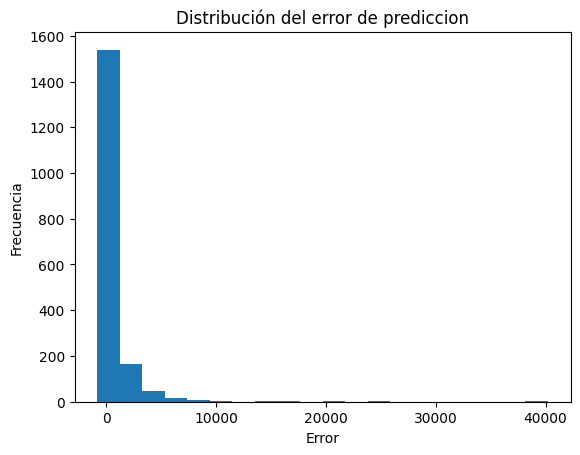

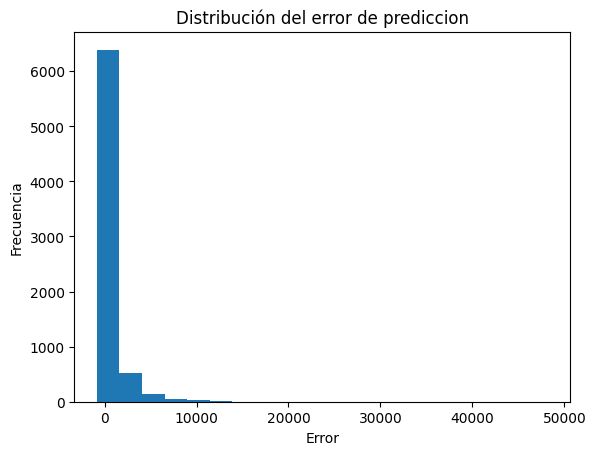

In [110]:
# Distribución del error de testeo

plt.hist(errores_test.tolist()[0], bins=20)
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.title('Distribución del error de prediccion')
plt.show()

# Distribución del error de entrenamiento

plt.hist(errores_train.tolist()[0], bins=20)
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.title('Distribución del error de prediccion')
plt.show()

In [89]:
np.unique(y_pred)

array([831.3315], dtype=float32)

In [112]:
# Calculo de cuantiles de errores testeo
print('Testo')
cuantiles =  [0.25, 0.5, 0.75]
quantiles = np.quantile(errores_test.tolist()[0], cuantiles)
for i in range(len(cuantiles)):
    print(f'Cuantil {int(cuantiles[i]*100)}%: {quantiles[i]}')

print('\nEntrenamiento')
# Calculo de cuantiles de errores entrenamiento
cuantiles =  [0.25, 0.5, 0.75]
quantiles = np.quantile(errores_train.tolist()[0], cuantiles)
for i in range(len(cuantiles)):
    print(f'Cuantil {int(cuantiles[i]*100)}%: {quantiles[i]}')

Testo
Cuantil 25%: -789.4489819335938
Cuantil 50%: -461.65148193359374
Cuantil 75%: 248.66851806640625

Entrenamiento
Cuantil 25%: -791.7614819335937
Cuantil 50%: -471.33148193359375
Cuantil 75%: 292.5810180664062


Como se observa en el histogramas tenemos errores de predicción y hay una gran mayoría que son inferiores a 0, menos del 50% de estos están por encima de 0 por lo tanto, se concluye que el modelo está subestimando las predicciones. La anterior idea es reforzada por el cáculo de los cuantiles ya que se observa que el 50% de los errores está por debajo de -471,331 tanto en testeo como en entrenamiento. Así qué, más del 50% de estos son negativos. 

**Nuevas predicciones**

In [91]:
# Eliminar variables no utiles para el modelo
X = purchase.drop('CUST_ID', axis = 1)
# Escalar las variables
X = escalador.transform(X)
# Predecir
y_pred_test = model.predict(X)

280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Se calcularán los intervalos y la estructura lógica de los 10 usuarios que tienen mayores compras y los 10 que tengan menos (Aunque sabemos que retornará valores iguales ya que las predicciones de la red son una constante)

In [114]:
dic = {i:y_pred_test.tolist()[i] for i in range(len(y_pred_test))}
dic_sorted = dict(sorted(dic.items(), key=lambda x: x[1]))

print("10 usuarios que tienen mayores compras")
for key in list(dic_sorted.keys())[:10]:
    print(key, ":", dic[key])

print("10 usuarios que tienen menores compras")
for key in list(dic_sorted.keys())[-10:]:
    print(key, ":", dic[key])


10 usuarios que tienen mayores compras
0 : [831.3314819335938]
1 : [831.3314819335938]
2 : [831.3314819335938]
3 : [831.3314819335938]
4 : [831.3314819335938]
5 : [831.3314819335938]
6 : [831.3314819335938]
7 : [831.3314819335938]
8 : [831.3314819335938]
9 : [831.3314819335938]
10 usuarios que tienen menores compras
8940 : [831.3314819335938]
8941 : [831.3314819335938]
8942 : [831.3314819335938]
8943 : [831.3314819335938]
8944 : [831.3314819335938]
8945 : [831.3314819335938]
8946 : [831.3314819335938]
8947 : [831.3314819335938]
8948 : [831.3314819335938]
8949 : [831.3314819335938]


Como era de esperarse los que tienen mayores compras o menores, son los 10 primeros y los 10 últimos

**Intervalos de confianza**

In [ ]:
# Cuantiles del 20 y 80

sd_inf = np.quantile(errores_test, 0.1)
sd_sup = np.quantile(errores_test, 0.9)

inter_inf = y_pred_test + sd_inf
inter_sup = y_pred_test + sd_sup

In [143]:
predict_intervalos = pd.DataFrame()
predict_intervalos['inferior'] = inter_inf.tolist()
predict_intervalos['ajuste'] = y_pred_test.tolist()
predict_intervalos['superior'] = inter_sup.tolist()

predict_intervalos.head(10)

,inferior,ajuste,superior
0,[0.0],[831.3314819335938],[2464.533935546875]
1,[0.0],[831.3314819335938],[2464.533935546875]
2,[0.0],[831.3314819335938],[2464.533935546875]
3,[0.0],[831.3314819335938],[2464.533935546875]
4,[0.0],[831.3314819335938],[2464.533935546875]
5,[0.0],[831.3314819335938],[2464.533935546875]
6,[0.0],[831.3314819335938],[2464.533935546875]
7,[0.0],[831.3314819335938],[2464.533935546875]
8,[0.0],[831.3314819335938],[2464.533935546875]
9,[0.0],[831.3314819335938],[2464.533935546875]


Estrategias para fidelizar clientes con muchas compras: 
- Ofrecer programas de fidelización que recompensen a los clientes por su lealtad y volumen de compras y personalizar las recompensas basándose en las preferencias y el historial de compras del cliente.

- Implementar un programa de fidelización por medio del cashback, teniendo en cuenta que son clientes que están usualmente haciendo compras por un ticket alto. Por comprar superiores a X cantidad de dinero, se le hará el retorno de Y% del efectivo al cliente. 

- Implementar programas de acumulación de puntos y rendención de los mismos por productos seleccionados o tarjetas redimibles. Este insentivo puede lograr aumentar la recompra por cliente y aumentar el ticket promedio de la compra en sí. 

- Ofrecer una comunicación personalizada y una experiencia de atención al cliente excepcional a través de diferentes canales para informar de ofertas, promociones o eventos exclusivos.

- Ofrecer servicios de atención prioritarios para resolvar cualquier problema o consulta que puedan tener de manera eficiente.

Estrategias para activar clientes que están usando muy poco las tarjetas.

- Enviar ofertas y promociones especiales para incentivar el uso de la tarjeta y aumentar sus compras.

- Proporcionar promociones temporales como descuentos del 10% en la próxima compra si usan la tarjeta en el próximo mes.

- Crear asociaciones con otras marcas y empresas para ofrecer descuentos y beneficios adicionales cuando se use la tarjeta en esos lugares.

- Ofrecer beneficios especiales por la reactivación de la tarjeta, como recompensas inmediatas.

- Hacer campañas de marketing específicas dirigidas a clientes inactivos o pasivos para recordarles la marca, productos o servicios cómo tal.
